In [16]:
#Khởi tạo SparkSession
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Diabetes").getOrCreate()

df = spark.read.csv(
    "output/cleaned_data.csv",
    header=True,
    inferSchema=True
)

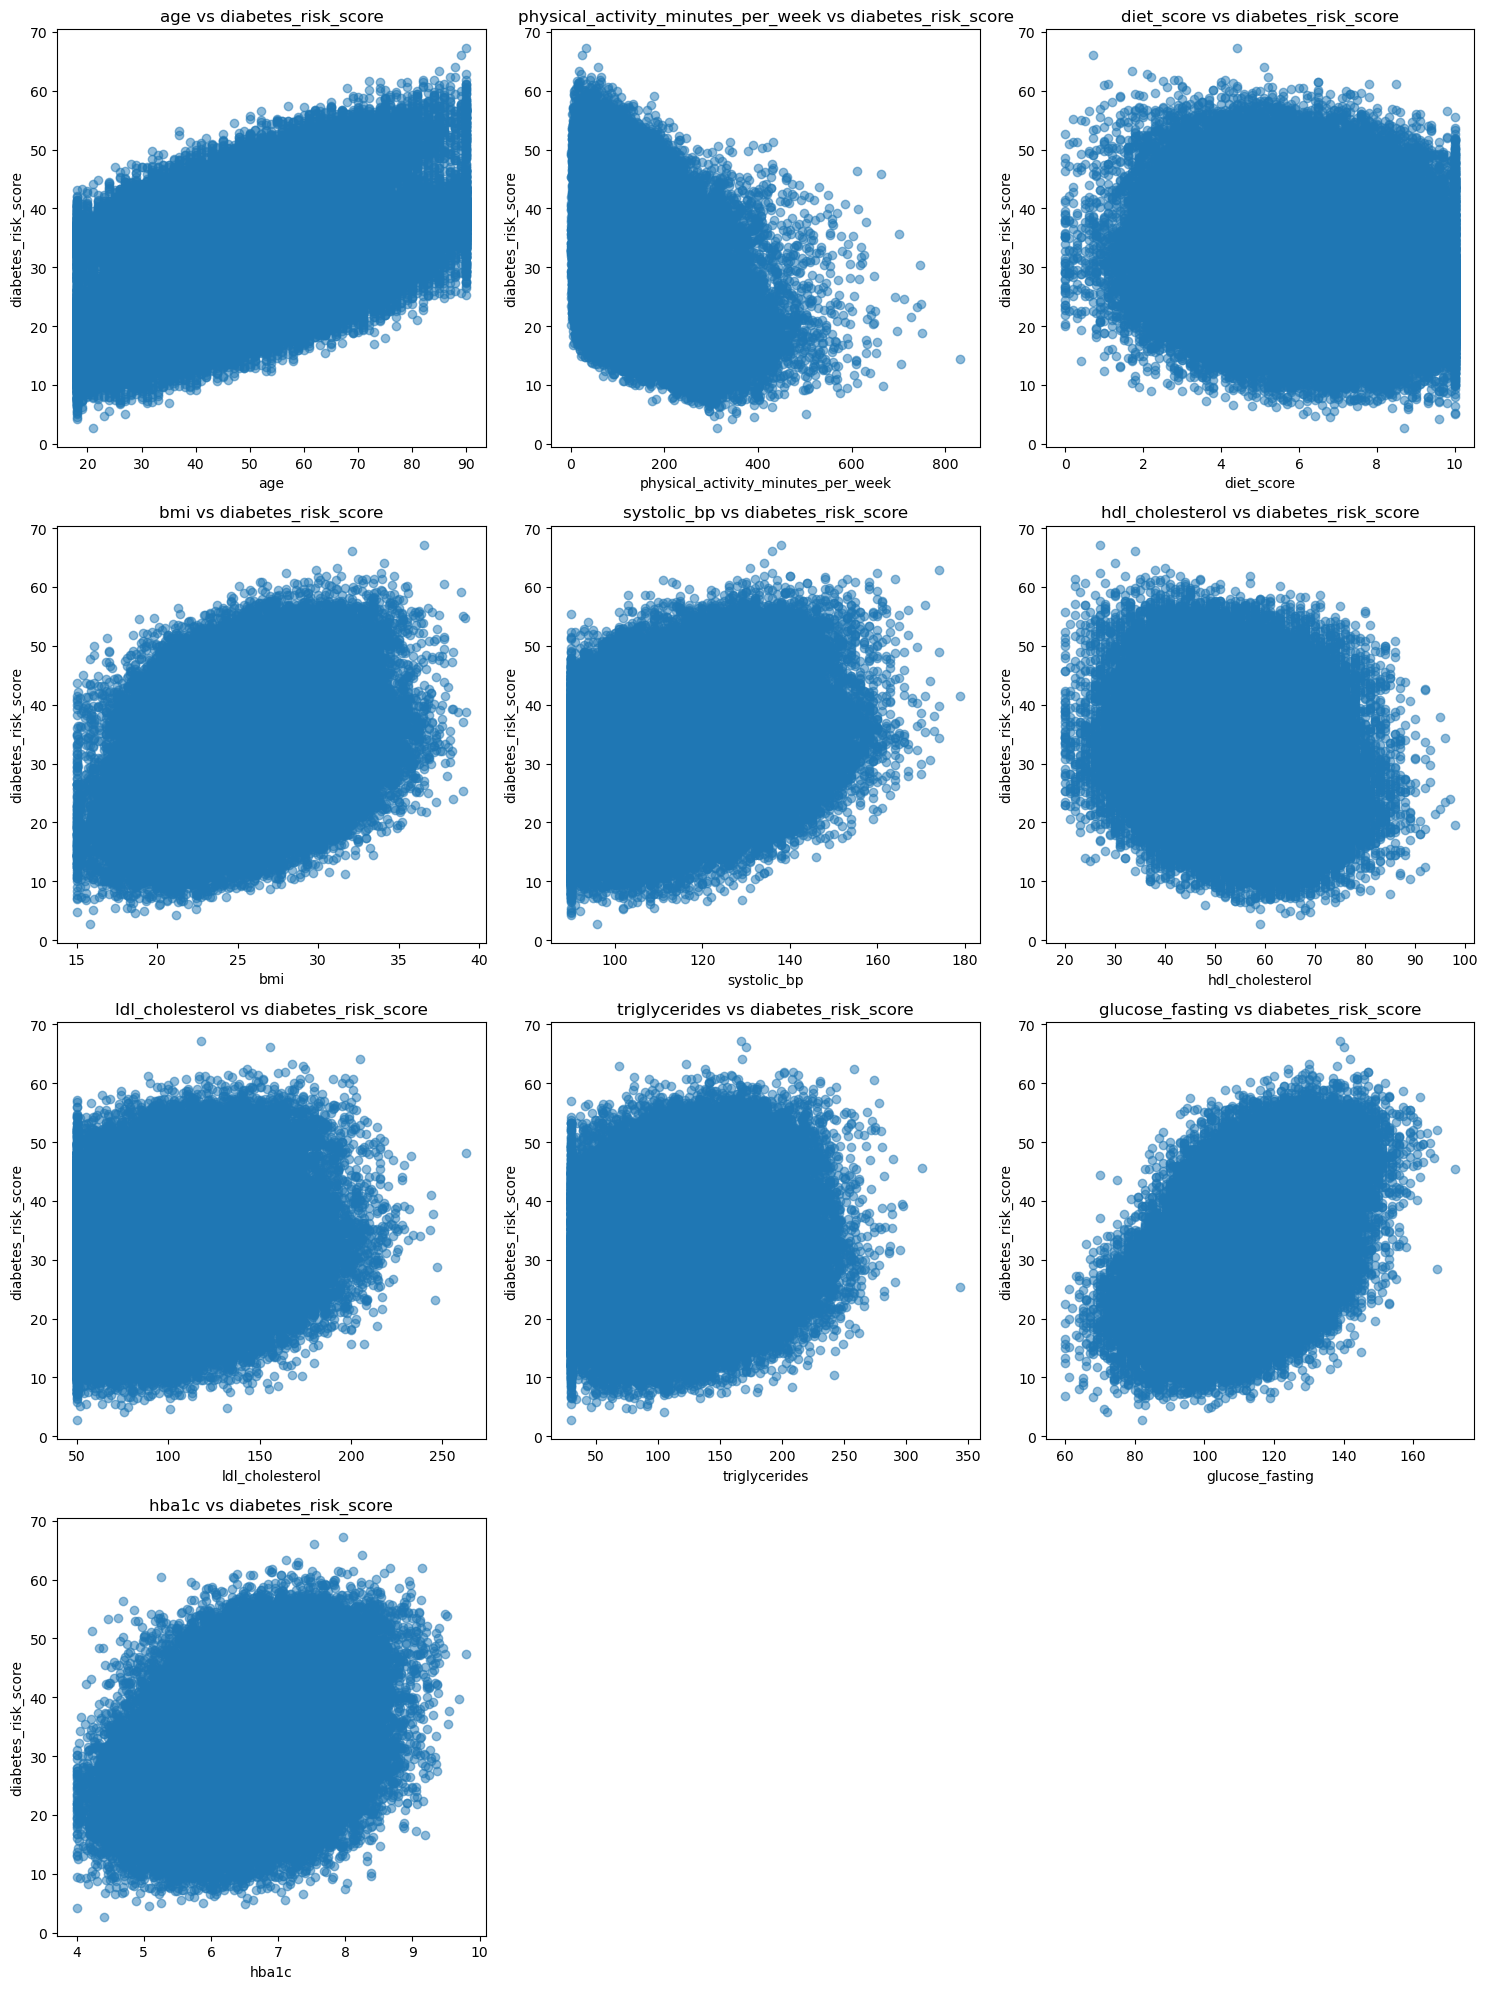

In [17]:
import matplotlib.pyplot as plt

features = [
    "age",
    "physical_activity_minutes_per_week",
    "diet_score",
    "bmi",
    "systolic_bp",
    "hdl_cholesterol",
    "ldl_cholesterol",
    "triglycerides",
    "glucose_fasting",
    "hba1c"
]
target = "diabetes_risk_score"

plot_df = df.select(features + [target]).dropna()
pdf = plot_df.toPandas()

n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols

plt.figure(figsize=(15, 5 * n_rows))

for i, col in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.scatter(pdf[col], pdf[target], alpha=0.5)
    plt.xlabel(col)
    plt.ylabel(target)
    plt.title(f"{col} vs {target}")

plt.tight_layout()
plt.show()


In [18]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

data = df.select(features + [target]).dropna()

assembler = VectorAssembler(inputCols=features, outputCol="features")
data_ml = assembler.transform(data).select("features", target)

train_data, test_data = data_ml.randomSplit([0.7, 0.3], seed=42)

lr = LinearRegression(featuresCol="features", labelCol=target)
lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)

# Né lỗi .show() nếu máy bạn đang bị bug show: dùng collect/first
rows = predictions.select(target, "prediction").limit(10).collect()
for r in rows:
    print("Actual:", r[target], " | Pred:", r["prediction"])





Actual: 22.2  | Pred: 28.896830718318004
Actual: 21.9  | Pred: 23.803243374519866
Actual: 39.5  | Pred: 29.043900090546362
Actual: 16.8  | Pred: 19.053290876044997
Actual: 24.3  | Pred: 24.47588587817114
Actual: 17.1  | Pred: 16.908968427004876
Actual: 22.7  | Pred: 26.729721299048652
Actual: 19.8  | Pred: 22.42523822016133
Actual: 18.7  | Pred: 25.100284614194756
Actual: 24.3  | Pred: 24.482946463899726


In [19]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_rmse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
evaluator_r2   = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")
evaluator_mae  = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mae")

rmse = evaluator_rmse.evaluate(predictions)
r2   = evaluator_r2.evaluate(predictions)
mae  = evaluator_mae.evaluate(predictions)

print("RMSE =", rmse)
print("MAE  =", mae)
print("R2   =", r2)


RMSE = 6.231377805845776
MAE  = 4.96634354601202
R2   = 0.5307582391825061


In [20]:
try:
    coefs = lr_model.coefficients
    intercept = lr_model.intercept
    print("Intercept:", intercept)
    for name, c in zip(features, coefs):
        print(f"{name}: {c}")
except NameError:
    print("Error: 'lr_model' is not defined. Run the training cell (LinearRegression fit) first.")
except Exception as e:
    print("Error when printing coefficients:", e)


Intercept: -3.370439062459565
age: 0.23838388012194367
physical_activity_minutes_per_week: -0.030910599310204713
diet_score: -0.4264538522115085
bmi: 0.3873330577154579
systolic_bp: -0.0021465505948972917
hdl_cholesterol: -0.08392818204660062
ldl_cholesterol: 0.0002488230317173186
triglycerides: 0.011357571454871348
glucose_fasting: 0.190342268483852
hba1c: 0.03108704828302272


In [21]:
features = [
    "age",
    "physical_activity_minutes_per_week",
    "diet_score",
    "bmi",
    "systolic_bp",
    "hdl_cholesterol",
    "ldl_cholesterol",
    "triglycerides",
    "glucose_fasting",
    "hba1c"
]
target = "diabetes_risk_score"

df_model = df.select(features + [target]).dropna()


In [22]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=features,
    outputCol="features"
)

df_final = assembler.transform(df_model).select("features", target)


In [23]:
train_df, test_df = df_final.randomSplit([0.7, 0.3], seed=42)
train_size = train_df.count()
test_size = test_df.count()
total_size = train_size + test_size

print("KÍCH THƯỚC TẬP DỮ LIỆU")
print(f"Train size: {train_size} mẫu ({train_size / total_size * 100:.2f}%)")
print(f"Test size : {test_size} mẫu ({test_size / total_size * 100:.2f}%)")
print(f"Total     : {total_size} mẫu")



KÍCH THƯỚC TẬP DỮ LIỆU
Train size: 69951 mẫu (69.95%)
Test size : 30049 mẫu (30.05%)
Total     : 100000 mẫu


In [24]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(
    featuresCol="features",
    labelCol=target
)

lr_model = lr.fit(train_df)


In [28]:
import pandas as pd

coef = lr_model.coefficients.toArray().tolist()
coef_df = pd.DataFrame({
    "feature": features,
    "coefficient": coef,
    "abs_coefficient": [abs(x) for x in coef]
}).sort_values("abs_coefficient", ascending=False)

print("\nTOP FEATURE ẢNH HƯỞNG MẠNH (theo |coefficient|):")
print(coef_df.head(10).to_string(index=False))
print("\nIntercept:", lr_model.intercept)




TOP FEATURE ẢNH HƯỞNG MẠNH (theo |coefficient|):
                           feature  coefficient  abs_coefficient
                        diet_score    -0.426454         0.426454
                               bmi     0.387333         0.387333
                               age     0.238384         0.238384
                   glucose_fasting     0.190342         0.190342
                   hdl_cholesterol    -0.083928         0.083928
                             hba1c     0.031087         0.031087
physical_activity_minutes_per_week    -0.030911         0.030911
                     triglycerides     0.011358         0.011358
                       systolic_bp    -0.002147         0.002147
                   ldl_cholesterol     0.000249         0.000249

Intercept: -3.370439062459565
